In [1]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import os
import geopandas as gpd
import sys
import scipy.stats as stats

/home/x1b3d3ad/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cwd = os.getcwd()
print(cwd)
dataPath = os.path.join(cwd, 'data')
austin_housing = pd.read_csv(os.path.join(dataPath, 'crime-housing-austin-2015.csv'))
zip_codes = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))

/home/x1b3d3ad/spring2024/dataScience/cs5830_project2


In [3]:
austin_housing.head()
austin_housing.columns

Index(['Key', 'Council_District', 'Highest_Offense_Desc',
       'Highest_NIBRS_UCR_Offense_Description', 'Report_Date', 'Location',
       'Clearance_Status', 'Clearance_Date', 'District', 'Zip_Code_Crime',
       'Census_Tract', 'X_Coordinate', 'Y_Coordinate', 'Zip_Code_Housing',
       'Populationbelowpovertylevel', 'Medianhouseholdincome',
       'Non-WhiteNon-HispanicorLatino', 'HispanicorLatinoofanyrace',
       'Populationwithdisability', 'Unemployment',
       'Largehouseholds(5+members)',
       'Homesaffordabletopeopleearninglessthan$50000',
       'Rentalsaffordabletopeopleearninglessthan$25000',
       'Rent-restrictedunits', 'HousingChoiceVoucherholders', 'Medianrent',
       'Medianhomevalue', 'Percentageofrentalunitsinpoorcondition',
       'Percentchangeinnumberofhousingunits2000-2012',
       'Ownerunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageartist',
       'Ownerunits

In [4]:
# zip_codes.head()
zip_codes.columns
zip_codes.tail()

,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank
44,45,78617,0,"Austin, Texas","23,020",0,#0
45,46,78660,0,"Austin, Texas","82,260",0,#0
46,47,78653,0,"Austin, Texas","20,120",0,#0
47,48,78652,0,"Austin, Texas","4,400",0,#0
48,49,78712,0,"Austin, Texas","1,000",0,#0


missing zip codes: Empty DataFrame
Columns: [Zip_Code, Total_Crime]
Index: []


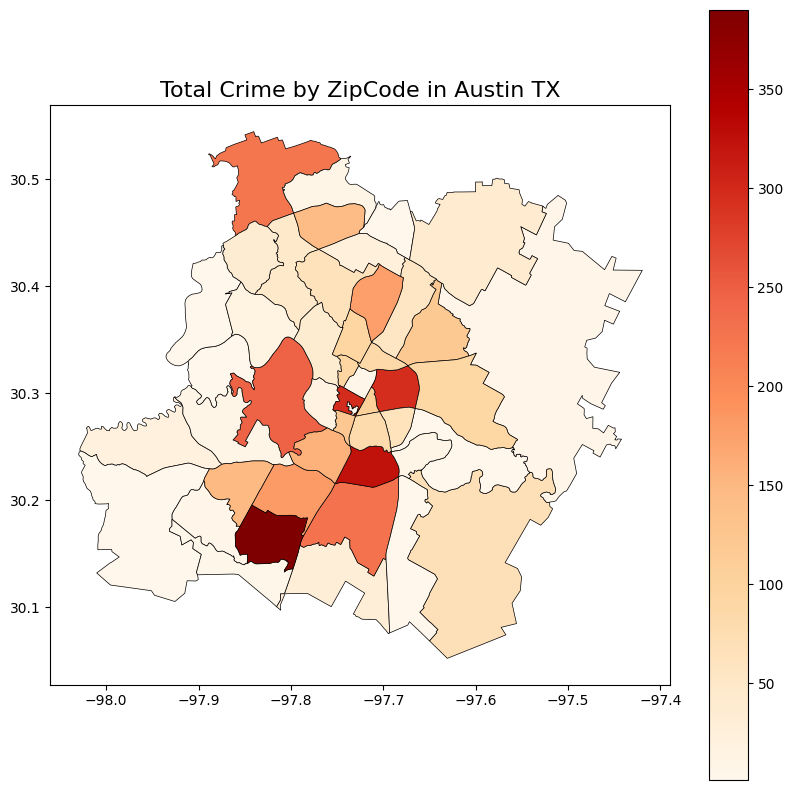

   Zip_Code  crime_per_1000
13    78754       22.132055
14    78722       16.967793
0     78748       15.377943
34    78742       14.400000
15    78756       13.327722
<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 13 to 12
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Zip_Code        47 non-null     object 
 1   crime_per_1000  47 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB
None


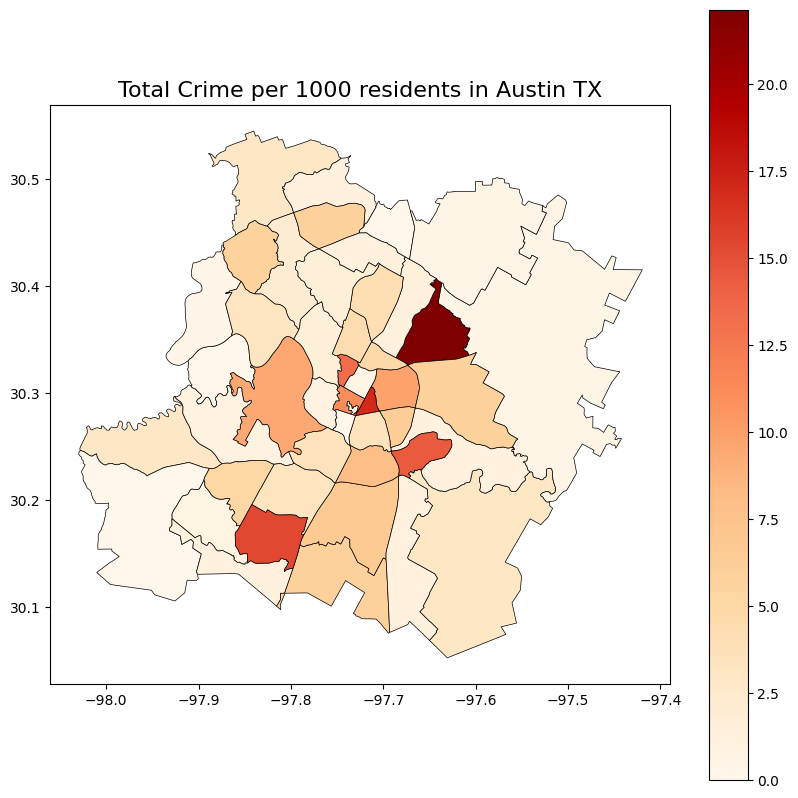

crime by month:
    Zip_Code Report_Date  Total_Crime
0     78753     2015-12          315
1     78753     2015-08          311
2     78753     2015-11          308
3     78753     2015-05          307
4     78753     2015-07          304
5     78753     2015-09          299
6     78753     2015-01          292
7     78753     2015-03          288
8     78741     2015-04          285
9     78741     2015-05          283
10    78741     2015-10          279
11    78753     2015-06          279
12    78753     2015-04          278
13    78741     2015-06          268
14    78741     2015-08          266
15    78701     2015-03          256
16    78753     2015-10          253
17    78741     2015-12          253
18    78741     2015-01          250
19    78704     2015-07          244
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   Zip_Code 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45],
 [Text(0, 0, '78719'),
  Text(1, 0, '78754'),
  Text(2, 0, '78702'),
  Text(3, 0, '78742'),
  Text(4, 0, '78723'),
  Text(5, 0, '78753'),
  Text(6, 0, '78741'),
  Text(7, 0, '78747'),
  Text(8, 0, '78748'),
  Text(9, 0, '78751'),
  Text(10, 0, '78752'),
  Text(11, 0, '78756'),
  Text(12, 0, '78722'),
  Text(13, 0, '78704'),
  Text(14, 0, '78744'),
  Text(15, 0, '78758'),
  Text(16, 0, '78757'),
  Text(17, 0, '78725'),
  Text(18, 0, '78705'),
  Text(19, 0, '78721'),
  Text(20, 0, '78726'),
  Text(21, 0, '78746'),
  Text(22, 0, '78745'),
  Text(23, 0, '78735'),
  Text(24, 0, '78703'),
  Text(25, 0, '78724'),
  Text(26, 0, '78759'),
  Text(27, 0, '78717'),
  Text(28, 0, '78739'),
  Text(29, 0, '78749'),
  Text(30, 0, '78727'),

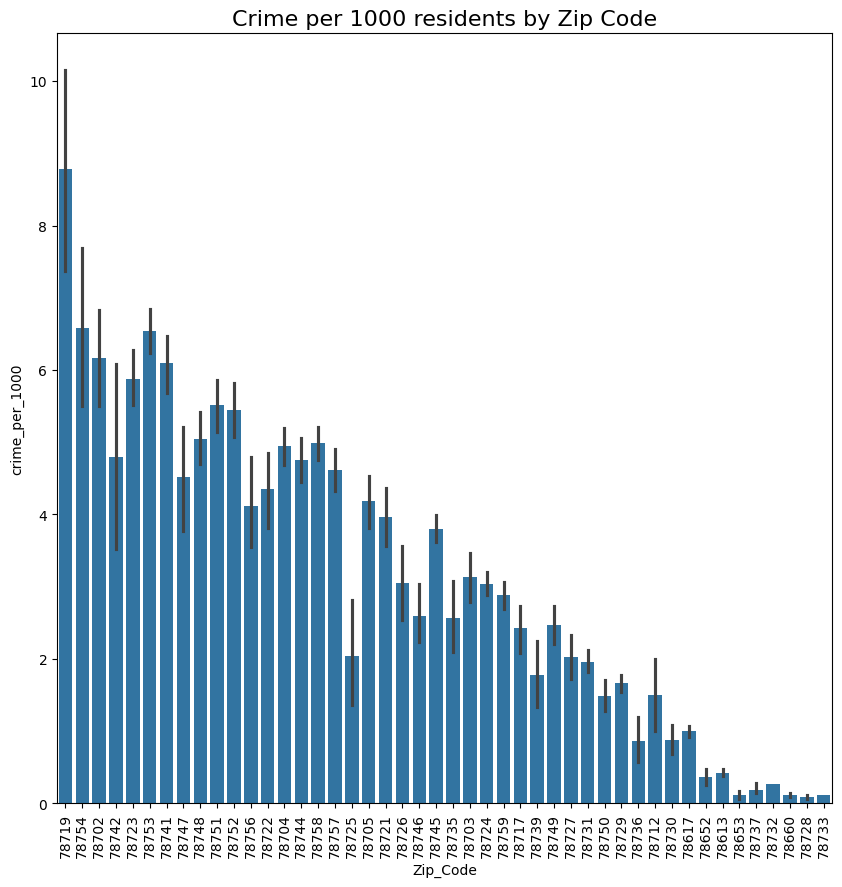

In [22]:
""" 
Karl's Spatial Analysis 
"""

""" 
Map of Austin TX  
https://openaustin.carto.com/u/oa-admin/tables/austin_area_zip_codes/public?redirected=true 
"""

df = austin_housing.copy()
# Date format: 01-Jan-15.  d=day, b=abbreviated month,y=2-digit year
# df['Report_Date'] = pd.to_datetime(df['Report_Date'], format='%d-%b-%y')

# Aggregate crimes by zip code
base_crime_df = df[['Zip_Code_Crime', 'Highest_Offense_Desc', 'Report_Date']].copy()
base_crime_df.rename(columns={'Zip_Code_Crime': 'Zip_Code'}, inplace=True)
base_crime_df.dropna(inplace=True)
base_crime_df['Zip_Code'] = base_crime_df['Zip_Code'].astype('int').astype('str')

# Group by zip code and crime type
crime_zip = base_crime_df.copy()
crime_zip = crime_zip[['Zip_Code', 'Highest_Offense_Desc']].copy()
crime_zip.groupby(['Zip_Code', 'Highest_Offense_Desc']).count()
crime_zip['Total_Crime'] = crime_zip.groupby(['Zip_Code', 'Highest_Offense_Desc'])['Highest_Offense_Desc'].transform('count')

# Process the crime_zip df to get zip codes and remove duplicates
crime_zip.drop_duplicates(subset=['Zip_Code'], inplace=True)
crime_zip.sort_values(by=['Total_Crime'], ascending=False, inplace=True)
crime_zip.reset_index(drop=True, inplace=True)
crime_zip.drop(columns=['Highest_Offense_Desc'], inplace=True)
crime_zip['Total_Crime'] = crime_zip['Total_Crime'].astype('int')

# Remove zip codes that do not show up in the AustinZipCodes.csv
# display the missing zip codes
missing_zip_codes = crime_zip[~crime_zip['Zip_Code'].isin(zip_codes['Zip Code'].astype('str'))]
crime_zip = crime_zip[crime_zip['Zip_Code'].isin(zip_codes['Zip Code'].astype('str'))]
print(f'missing zip codes: {missing_zip_codes}')

# Load the GeoDataFrame and merge it with crime_zip
austinMap = gpd.read_file(os.path.join(dataPath, 'austin_area_zip_codes.geojson'))
austinMap['zipcode'] = austinMap['zipcode'].astype('str')

# Merge num crimes per zip with the austin map 
austinMapCrimeZip = austinMap.copy()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMapCrimeZip = austinMapCrimeZip.merge(crime_zip, left_on='zipcode', right_on='Zip_Code', how='left')

# Plot the GeoDataFrame
austinMapCrimeZip.plot(ax=ax, figsize=(10, 10), column='Total_Crime', cmap='OrRd', linewidth=0.5, edgecolor='black', legend=True)
ax.set_title('Total Crime by ZipCode in Austin TX', fontsize=16)
plt.show()



"""
Make a new column, titled theft_crime_rate, that is the number of crimes per 1000 people
"""
crime_rate = crime_zip[['Zip_Code', 'Total_Crime']].copy()
population_zip = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))
population_zip = population_zip[['Zip Code', 'Population']].copy()
population_zip['Zip Code'] = population_zip['Zip Code'].astype('str')

# Remove 78701 from the population_zip df as it is a huge outlier
population_zip = population_zip[population_zip['Zip Code'] != '78701']

# Convert population into an int
population_zip['Population'] = population_zip['Population'].str.replace(',', '')
population_zip['Population'] = population_zip['Population'].astype('int')

# Merge population_zip with crime_rate
crime_rate = crime_rate.merge(population_zip, left_on='Zip_Code', right_on='Zip Code', how='left')
crime_rate['crime_per_1000'] = crime_rate['Total_Crime'] / (crime_rate['Population'] / 1000)
crime_rate.sort_values(by=['crime_per_1000'], ascending=False, inplace=True)
crime_rate.drop(columns=['Total_Crime', 'Zip Code', 'Population'], inplace=True)
crime_rate['crime_per_1000'] = crime_rate['crime_per_1000'].fillna(0)
# crime_rate.dropna(inplace=True)
print(crime_rate.head(5))
print(crime_rate.info())

# Plot the population with the geojson map 
# Analysis: How correlated is the number of crimes to the population of a zip code?
austinMapCrimeRate = austinMap.copy()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMapCrimeRate = austinMapCrimeRate.merge(crime_rate, left_on='zipcode', right_on='Zip_Code', how='left')
austinMapCrimeRate.plot(ax=ax, figsize=(10, 10), column='crime_per_1000', 
                        cmap='OrRd', linewidth=0.5, edgecolor='black', 
                        legend=True, )
ax.set_title('Total Crime per 1000 residents in Austin TX', fontsize=16)
plt.show()


""" Group by zip code and month """
crime_by_month = base_crime_df.copy()
crime_by_month['Report_Date'] = pd.to_datetime(crime_by_month['Report_Date'], format='%d-%b-%y')
crime_by_month.groupby(['Zip_Code', 'Report_Date']).count()
# convert the date to a month
crime_by_month['Report_Date'] = crime_by_month['Report_Date'].dt.to_period('M')
crime_by_month['Total_Crime'] = crime_by_month.groupby(['Zip_Code', 'Report_Date'])['Highest_Offense_Desc'].transform('count')
crime_by_month.drop_duplicates(subset=['Zip_Code', 'Report_Date'], inplace=True)
crime_by_month.sort_values(by=['Total_Crime'], ascending=False, inplace=True)
crime_by_month.reset_index(drop=True, inplace=True)
crime_by_month.drop(columns=['Highest_Offense_Desc'], inplace=True)
crime_by_month.dropna(inplace=True)
print(f'crime by month:\n {crime_by_month.head(20)}')


# Calculate the crime_per_1000 residents for each month per zip code
crime_by_month_rate = crime_by_month.copy()
crime_by_month_rate = crime_by_month_rate.merge(population_zip, left_on='Zip_Code', right_on='Zip Code', how='left')
crime_by_month_rate['crime_per_1000'] = crime_by_month_rate['Total_Crime'] / (crime_by_month_rate['Population'] / 1000)
crime_by_month_rate.drop(columns=['Total_Crime'], inplace=True)
crime_by_month_rate.sort_values(by=['crime_per_1000'], ascending=False, inplace=True)


# Remove zip code 78701 from the crime_by_month_rate df
crime_by_month_rate = crime_by_month_rate[crime_by_month_rate['Zip_Code'] != '78701']

# Calculate the crime_rate_per_1000 for each month per zip code, then perform a t-test
# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*[group["crime_per_1000"] for name, group in crime_by_month_rate.groupby("Zip_Code")])

# Print results
print("Kruskal-Wallis Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:  # You may choose a different significance level
    print("The Kruskal-Wallis test suggests that there are significant differences in crime rates across different zip codes.")
else:
    print("The Kruskal-Wallis test does not provide enough evidence to suggest significant differences in crime rates across different zip codes.")

# Graph the crime rates for each zip code in a bar plot 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x='Zip_Code', y='crime_per_1000', data=crime_by_month_rate, ax=ax)
ax.set_title('Crime per 1000 residents by Zip Code', fontsize=16)
plt.xticks(rotation=90)
